<a href="https://colab.research.google.com/github/ishaqmarashy/Housing-Prices-ML/blob/main/Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Common imports
import os
import urllib
import io
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [145]:
raw_train_url = "https://raw.githubusercontent.com/ishaqmarashy/Housing-Prices-ML/main/train.csv"
raw_test_url = "https://raw.githubusercontent.com/ishaqmarashy/Housing-Prices-ML/main/test.csv"
def load_data(url):
  # download the csv file from github
  download = requests.get(url).content
  # read the downloaded content and put into dataframe
  df = pd.read_csv(io.StringIO(download.decode("utf-8")),index_col=0,infer_datetime_format=True,dayfirst=False)
  return df

In [146]:
train_df = load_data(raw_train_url)
test_df = load_data(raw_test_url)
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [147]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


# Some data is missing but we only require age from the missing values
# Drop the irrelevant data 'Name','Cabin','Ticket','Embarked'
def process(df):
  imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  df=pd.DataFrame(imp.fit_transform(df),columns=df.columns,index=df.index)
  if df.columns.isin(['Alley','Fence','MiscFeature','MoSold','YrSold']).any():
    df=df.drop(columns=['Alley','Alley','Fence','MiscFeature','MoSold','YrSold'])
  # We know age and sex played an important role in the survival of the sinking titanic
  # We can use that to engineer a new feature
  return df
train_df=process(train_df)
test_df=process(test_df)
train_df.info() 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   MSZoning       1460 non-null   object
 2   LotFrontage    1460 non-null   object
 3   LotArea        1460 non-null   object
 4   Street         1460 non-null   object
 5   LotShape       1460 non-null   object
 6   LandContour    1460 non-null   object
 7   Utilities      1460 non-null   object
 8   LotConfig      1460 non-null   object
 9   LandSlope      1460 non-null   object
 10  Neighborhood   1460 non-null   object
 11  Condition1     1460 non-null   object
 12  Condition2     1460 non-null   object
 13  BldgType       1460 non-null   object
 14  HouseStyle     1460 non-null   object
 15  OverallQual    1460 non-null   object
 16  OverallCond    1460 non-null   object
 17  YearBuilt      1460 non-null   object
 18  YearRemodAdd   1460 non-null

In [148]:
from sklearn import preprocessing
train_df = train_df.select_dtypes(exclude=[np.number])
le={}
for i in train_df:
  try :
    train_df[i]=train_df[i].astype(dtype='float32')
    test_df[i]=test_df[i].astype(dtype='float32')
  except :
      0
for i in train_df.select_dtypes('object'):
  label_encoder = preprocessing.LabelEncoder()
  if i in test_df.columns:
    label_encoder.fit(list(test_df[i].unique())+list(train_df[i].unique()))
    test_df[i]=label_encoder.transform(test_df[i])
  else:
    label_encoder.fit(list(train_df[i].unique()))
  train_df[i]=label_encoder.transform(train_df[i])
  le[i]=label_encoder

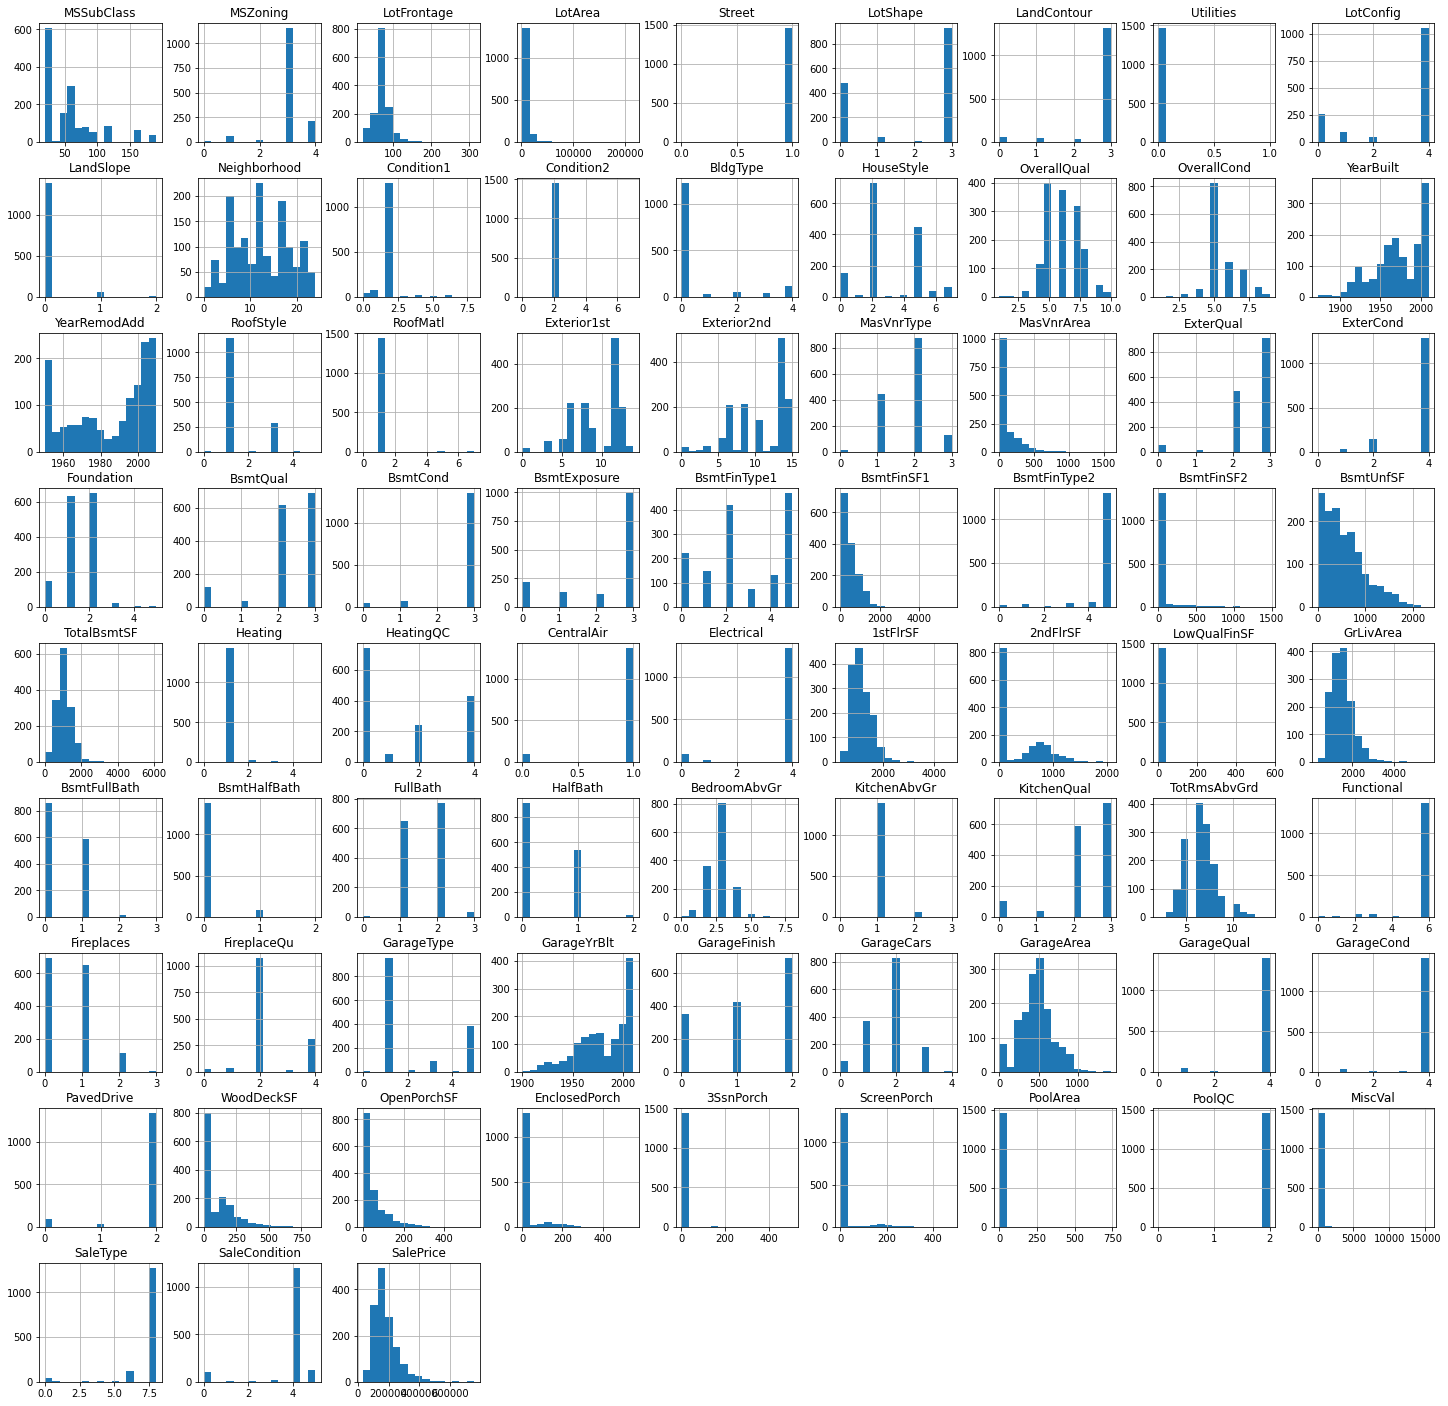

In [149]:
train_df.describe()
train_df.hist(bins=15, figsize=(25,25))
plt.show()

In [150]:
corr_matrix = train_df.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
                  ...   
HeatingQC      -0.400178
GarageFinish   -0.537242
KitchenQual    -0.589189
BsmtQual       -0.618025
ExterQual      -0.636884
Name: SalePrice, Length: 75, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f56a60d60>,
      dtype=object)

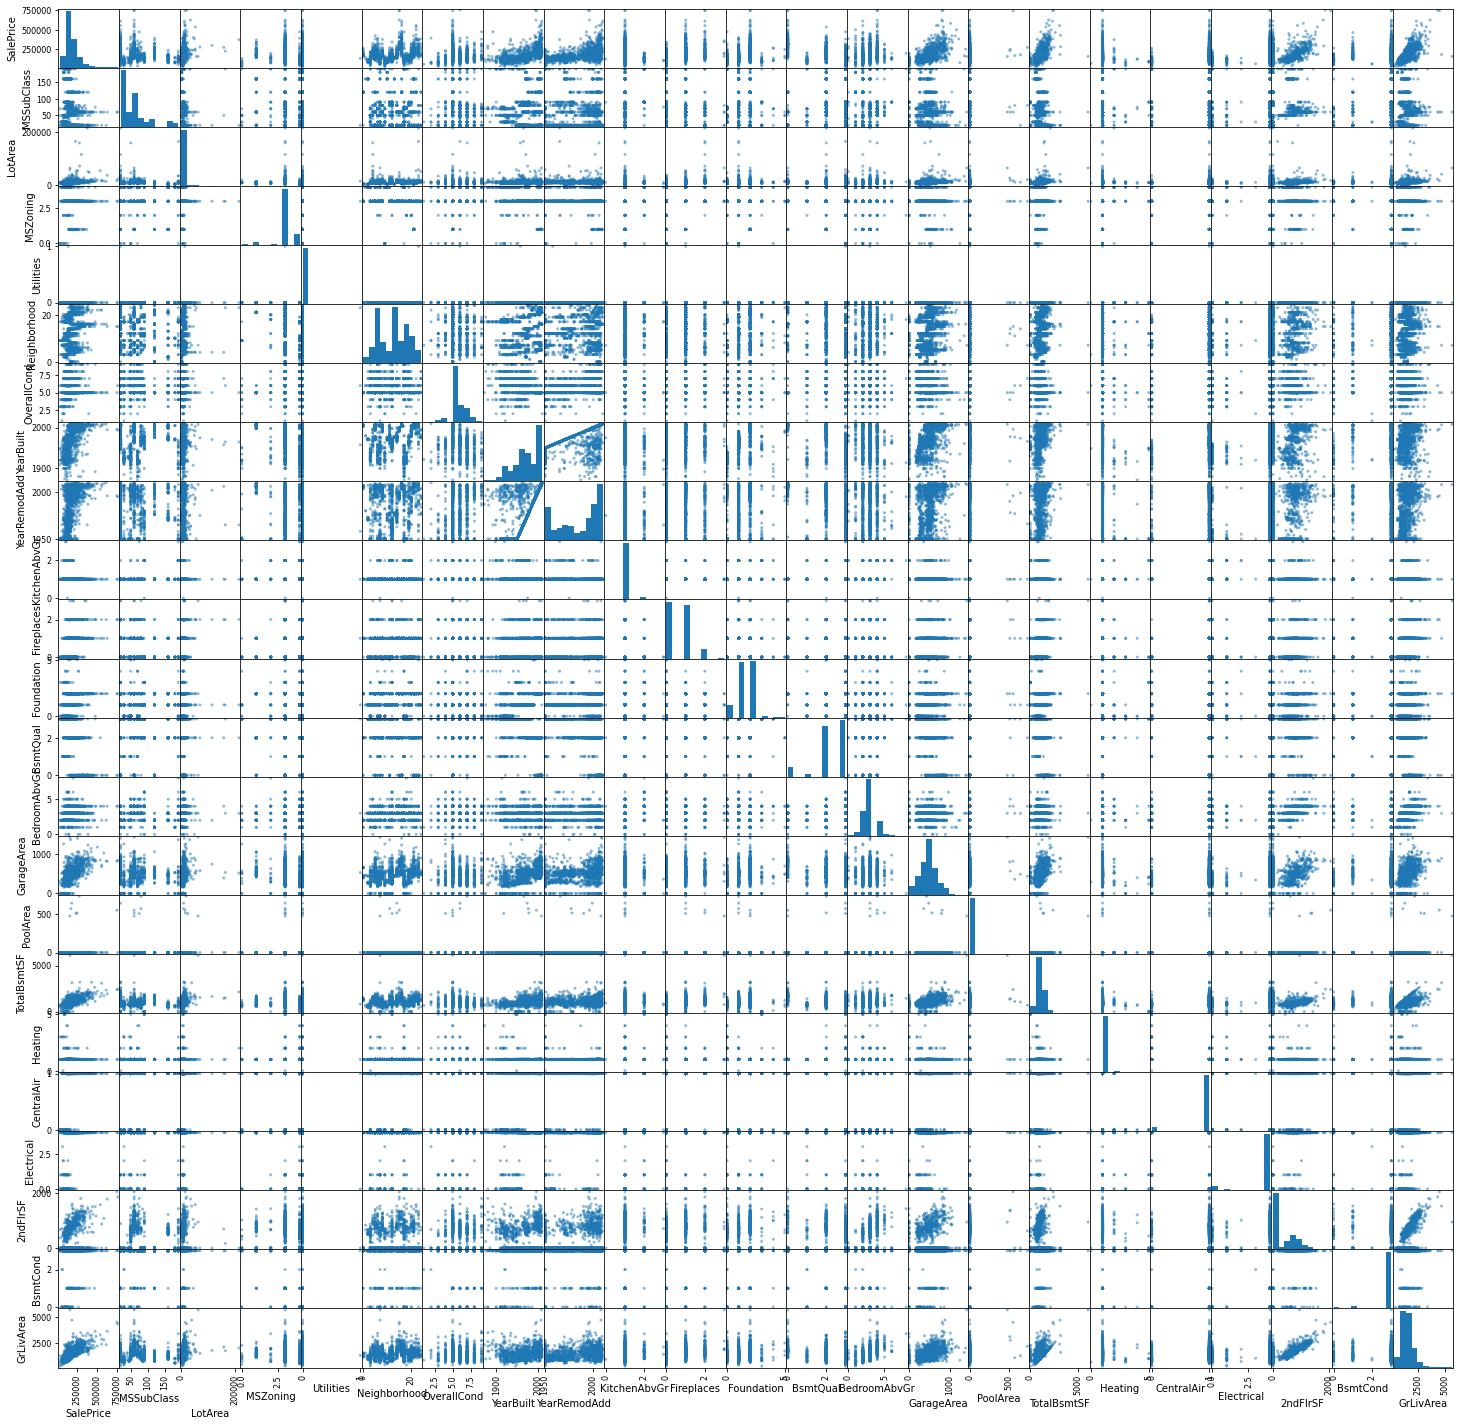

In [151]:
from pandas.plotting import scatter_matrix
plotted_features=['SalePrice','MSSubClass','LotArea','MSZoning','Utilities','Neighborhood','OverallCond','YearBuilt',
                  'YearRemodAdd', 'KitchenAbvGr','Fireplaces','Foundation','BsmtQual','BedroomAbvGr',
                  'GarageArea','PoolArea','TotalBsmtSF','Heating','CentralAir','Electrical','2ndFlrSF','BsmtCond','GrLivArea']
scatter_matrix(train_df[plotted_features], figsize=(25, 25))


In [152]:
X = train_df.drop("SalePrice", axis=1)
y = train_df["SalePrice"]
X_Pred=test_df
# 70% of the training data is being kept seperate to evaluate the model
# 30% goes in Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [156]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = make_pipeline(OneHotEncoder(handle_unknown='ignore'),LinearRegression())
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred=model.predict(X_test)
mae_pred_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train MAE: {mae_pred_train}')

Train MAE: 0.019155714289377613


In [157]:
# Metrics on how the data deals with the test set
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

1296618820.1700902


In [158]:
y_pred_test=model.predict(X_Pred)
X_Pred['SalePrice']=y_pred_test
y_pred_test_df=X_Pred['SalePrice']
X_Pred=X_Pred.drop(columns=['SalePrice'])
#y_pred_test_df.to_csv('submission.csv', index=False)